# Graph-based Machine Learning Algorithm applying on Biomedical Knowledge Graph


1.   Evaluating each model via citation network
2.   Applying the Hetionet database on the best-performance model



## Preparation

In [ ]:
!pip install stellargraph
!pip install py2neo

In [324]:
import pandas as pd
import py2neo
from stellargraph import StellarDiGraph, StellarGraph
from sklearn import preprocessing
import numpy as np
from stellargraph import datasets

Hetio_graph = py2neo.Graph("bolt+s://neo4j.het.io:7687")

In [325]:
# Return a result data frame
def match_in_hetio(graph, query):
    cursor = graph.run(query)
    result_df = pd.DataFrame.from_records(cursor, columns=cursor.keys())
    return result_df

### Import Citation Network

In [326]:
dataset = datasets.Cora()
G, _ = dataset.load(subject_as_feature=True)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 2708, Edges: 5429

 Node types:
  paper: [2708]
    Features: float32 vector, length 1440
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [5429]
        Weights: all 1 (default)
        Features: none


## Link prediction with GCN

In [327]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import FullBatchLinkGenerator
from stellargraph.layer import GCN, LinkEmbedding


from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar
%matplotlib inline

### Parameters

In [328]:
# data splitting
p = 0.2

# Creating the GCN link model
learning_rate = 1e-3
epochs = 100

### Data splitting

In [329]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G, and obtain the
# reduced graph G_test with the sampled links removed:
G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p, method="global", keep_connected=True
)

** Sampled 1085 positive and 1085 negative edges. **


In [330]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

# Randomly sample a fraction p=0.1 of all positive links, and same number of negative links, from G_test, and obtain the
# reduced graph G_train with the sampled links removed:
G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p, method="global", keep_connected=True
)

** Sampled 868 positive and 868 negative edges. **


### Creating the GCN link model

In [331]:
train_gen = FullBatchLinkGenerator(G_train, method="gcn")
train_flow = train_gen.flow(edge_ids_train, edge_labels_train)

Using GCN (local pooling) filters...


In [332]:
test_gen = FullBatchLinkGenerator(G_test, method="gcn")
test_flow = train_gen.flow(edge_ids_test, edge_labels_test)

Using GCN (local pooling) filters...


In [333]:
gcn = GCN(
    layer_sizes = [16, 16],
    activations = ["relu", "relu"],
    generator=train_gen, 
    dropout=0.4
    # bias=True,
)

In [334]:
x_inp, x_out = gcn.in_out_tensors()

In [341]:
prediction = LinkEmbedding(activation="relu", method="ip")(x_out)

In [342]:
prediction = keras.layers.Reshape((-1,))(prediction)

In [343]:
model = keras.Model(inputs=x_inp, outputs=prediction)
# ????????????????????????????????????????
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

In [344]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 53ms/step - loss: 1.5150 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 1.4947
	binary_accuracy: 0.5006

Test Set Metrics of the initial (untrained) model:
	loss: 1.5150
	binary_accuracy: 0.5000


### Train the model:

In [345]:
history = model.fit(
    train_flow, epochs = epochs, validation_data = test_flow, verbose = 2, shuffle = False
)

Epoch 1/100
1/1 - 1s - loss: 1.4325 - binary_accuracy: 0.5006 - val_loss: 1.2941 - val_binary_accuracy: 0.5014 - 1s/epoch - 1s/step
Epoch 2/100
1/1 - 0s - loss: 1.2076 - binary_accuracy: 0.5017 - val_loss: 1.1109 - val_binary_accuracy: 0.5051 - 77ms/epoch - 77ms/step
Epoch 3/100
1/1 - 0s - loss: 1.0396 - binary_accuracy: 0.5127 - val_loss: 0.9617 - val_binary_accuracy: 0.5124 - 85ms/epoch - 85ms/step
Epoch 4/100
1/1 - 0s - loss: 0.9362 - binary_accuracy: 0.5271 - val_loss: 0.8502 - val_binary_accuracy: 0.5346 - 80ms/epoch - 80ms/step
Epoch 5/100
1/1 - 0s - loss: 0.8434 - binary_accuracy: 0.5449 - val_loss: 0.7712 - val_binary_accuracy: 0.5604 - 78ms/epoch - 78ms/step
Epoch 6/100
1/1 - 0s - loss: 0.8050 - binary_accuracy: 0.5651 - val_loss: 0.7507 - val_binary_accuracy: 0.5894 - 75ms/epoch - 75ms/step
Epoch 7/100
1/1 - 0s - loss: 0.8083 - binary_accuracy: 0.5887 - val_loss: 0.7753 - val_binary_accuracy: 0.5876 - 74ms/epoch - 74ms/step
Epoch 8/100
1/1 - 0s - loss: 1.0393 - binary_accurac

Plot the training history:

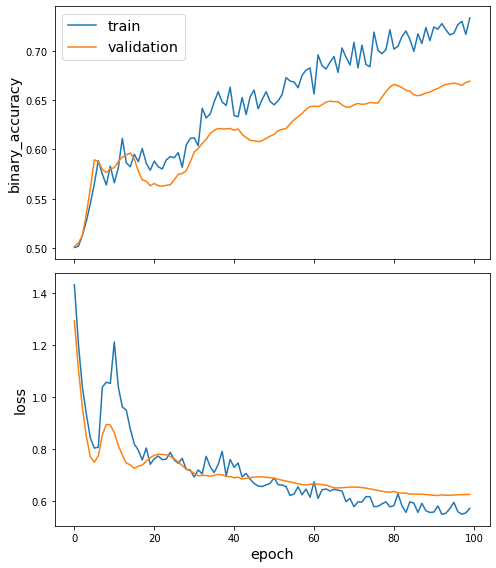

In [346]:
sg.utils.plot_history(history)

### Evaluate

In [347]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 56ms/step - loss: 0.6268 - binary_accuracy: 0.6691

Train Set Metrics of the trained model:
	loss: 0.4975
	binary_accuracy: 0.7627

Test Set Metrics of the trained model:
	loss: 0.6268
	binary_accuracy: 0.6691


## Link prediction with HinSAGE



In [348]:
from stellargraph.mapper import GraphSAGELinkGenerator
from stellargraph.layer import GraphSAGE, HinSAGE, link_classification

from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression
from tensorflow.keras import Model, optimizers, losses, metrics

from tensorflow import keras
from sklearn import preprocessing, feature_extraction, model_selection

from stellargraph import globalvar

### Parameters

In [382]:
p = 0.2
batch_size = 10
epochs = 10
num_samples = [16, 12]
layer_sizes = [20, 20]
learning_rate = 1e-3

### Dara Splitting

In [383]:
# Define an edge splitter on the original graph G:
edge_splitter_test = EdgeSplitter(G)

G_test, edge_ids_test, edge_labels_test = edge_splitter_test.train_test_split(
    p = p, method = "global", keep_connected = True
)

** Sampled 1085 positive and 1085 negative edges. **


In [384]:
# Define an edge splitter on the reduced graph G_test:
edge_splitter_train = EdgeSplitter(G_test)

G_train, edge_ids_train, edge_labels_train = edge_splitter_train.train_test_split(
    p = p, method = "global", keep_connected = True
)

** Sampled 868 positive and 868 negative edges. **


### Creating the HinSAGE model

In [385]:
train_gen = HinSAGELinkGenerator(G_train, batch_size, num_samples)
train_flow = train_gen.flow(edge_ids_train, edge_labels_train, shuffle=True)

test_gen = HinSAGELinkGenerator(G_test, batch_size, num_samples)
test_flow = test_gen.flow(edge_ids_test, edge_labels_test)

In [386]:
graphsage = HinSAGE(
    layer_sizes=layer_sizes, generator=train_gen, bias=True, dropout=0.4
)

In [387]:
x_inp, x_out = graphsage.in_out_tensors()

In [388]:
prediction = link_regression(edge_embedding_method = "mul")(x_out)

link_regression: using 'mul' method to combine node embeddings into edge embeddings


In [389]:
model = Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate = learning_rate),
    loss=keras.losses.binary_crossentropy,
    metrics=["binary_accuracy"],
)

### Evaluate

In [390]:
init_train_metrics = model.evaluate(train_flow)
init_test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

217/217 [==============================] - 4s 20ms/step - loss: 2.3599 - binary_accuracy: 0.5000

Train Set Metrics of the initial (untrained) model:
	loss: 2.2313
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 2.3599
	binary_accuracy: 0.5000


### Train

In [391]:
history = model.fit(train_flow, epochs=epochs, validation_data=test_flow)

Epoch 1/10
174/174 [==============================] - 10s 43ms/step - loss: 0.9831 - binary_accuracy: 0.5000 - val_loss: 0.6981 - val_binary_accuracy: 0.5000
Epoch 2/10
174/174 [==============================] - 8s 43ms/step - loss: 0.7168 - binary_accuracy: 0.5000 - val_loss: 0.6781 - val_binary_accuracy: 0.6203
Epoch 3/10
174/174 [==============================] - 8s 43ms/step - loss: 0.6764 - binary_accuracy: 0.5645 - val_loss: 0.6731 - val_binary_accuracy: 0.5673
Epoch 4/10
174/174 [==============================] - 8s 44ms/step - loss: 0.6485 - binary_accuracy: 0.6382 - val_loss: 0.6622 - val_binary_accuracy: 0.5820
Epoch 5/10
174/174 [==============================] - 8s 43ms/step - loss: 0.6103 - binary_accuracy: 0.6941 - val_loss: 0.6290 - val_binary_accuracy: 0.6461
Epoch 6/10
174/174 [==============================] - 8s 43ms/step - loss: 0.5652 - binary_accuracy: 0.7229 - val_loss: 0.6080 - val_binary_accuracy: 0.6728
Epoch 7/10
174/174 [==============================] - 8s 

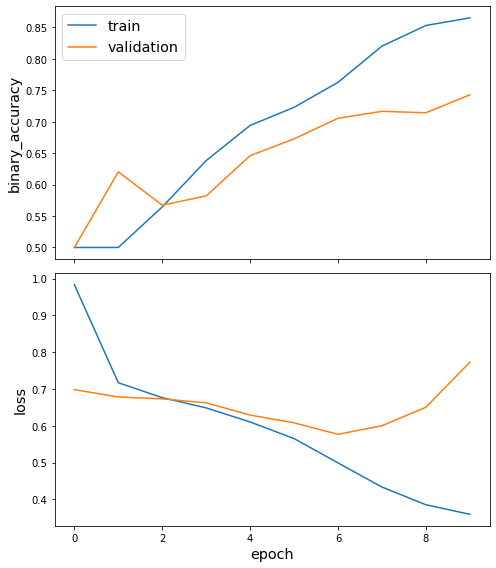

In [392]:
sg.utils.plot_history(history)

### Evaluate on test set

In [393]:
train_metrics = model.evaluate(train_flow)
test_metrics = model.evaluate(test_flow)

print("\nTrain Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the trained model:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

217/217 [==============================] - 4s 20ms/step - loss: 0.7744 - binary_accuracy: 0.7346

Train Set Metrics of the trained model:
	loss: 0.2649
	binary_accuracy: 0.9240

Test Set Metrics of the trained model:
	loss: 0.7744
	binary_accuracy: 0.7346


## Link Prediction with ComplEx





In [394]:
from stellargraph import utils
from tensorflow.keras import callbacks, optimizers, losses, metrics, regularizers, Model
import numpy as np
import pandas as pd

from stellargraph.mapper import KGTripleGenerator
from stellargraph.layer import ComplEx

### Parameters

In [395]:
epochs = 10
embedding_dimension = 200
negative_samples = 10
learning_rate = 1e-3

### Data Splitting

In [396]:
def get_complex_edge_df(edges):
    source = []
    target = []
    label = []
    for i in range(len(edges)):
        source.append(edges[i][0])
        target.append(edges[i][1])
        label.append(edges[i][2])
    
    dic = {
        "source":source,
        "label":label,
        "target":target
    }

    complex_edge_df = pd.DataFrame(data = dic)

    return complex_edge_df

In [397]:
edges = G.edges(include_edge_type = True)

In [398]:
complex_edge_df = get_complex_edge_df(edges)

In [399]:
train, validation, test = np.split(complex_edge_df.sample(frac = 1, random_state = 42),
                                    [int(.7*len(complex_edge_df)), int(.9*len(complex_edge_df))])

### Generator

In [400]:
generator = KGTripleGenerator(
    G, batch_size = len(train) // 100
)

In [401]:
train_gen = generator.flow(
    train, negative_samples = negative_samples, shuffle = True
)

validation_gen = generator.flow(
    validation, negative_samples = negative_samples
)

In [402]:
Complex = ComplEx(
    generator,
    embedding_dimension = embedding_dimension,
    embeddings_regularizer = regularizers.l2(1e-7)
)

### Model

In [403]:
x_inp, x_out = Complex.in_out_tensors()

In [404]:
model = Model(inputs = x_inp, outputs = x_out)

In [405]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = learning_rate),
    loss = losses.BinaryCrossentropy(from_logits = True),
    metrics = [metrics.BinaryAccuracy(threshold = 0.0)],
)

### Train

In [406]:
es = callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [407]:
history = model.fit(
    train_gen, validation_data = validation_gen, epochs = epochs, callbacks = [es]
    )

Epoch 1/10
100/100 [==============================] - 2s 9ms/step - loss: 0.6934 - binary_accuracy: 0.4999 - val_loss: 0.6934 - val_binary_accuracy: 0.5085
Epoch 2/10
100/100 [==============================] - 1s 6ms/step - loss: 0.6932 - binary_accuracy: 0.5379 - val_loss: 0.6933 - val_binary_accuracy: 0.5163
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 0.6922 - binary_accuracy: 0.6330 - val_loss: 0.6909 - val_binary_accuracy: 0.7204
Epoch 4/10
100/100 [==============================] - 1s 6ms/step - loss: 0.6770 - binary_accuracy: 0.8958 - val_loss: 0.6498 - val_binary_accuracy: 0.9092
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 0.5605 - binary_accuracy: 0.9094 - val_loss: 0.4583 - val_binary_accuracy: 0.9091
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 0.3618 - binary_accuracy: 0.9091 - val_loss: 0.3265 - val_binary_accuracy: 0.9091
Epoch 7/10
100/100 [==============================] - 1s 6ms/ste

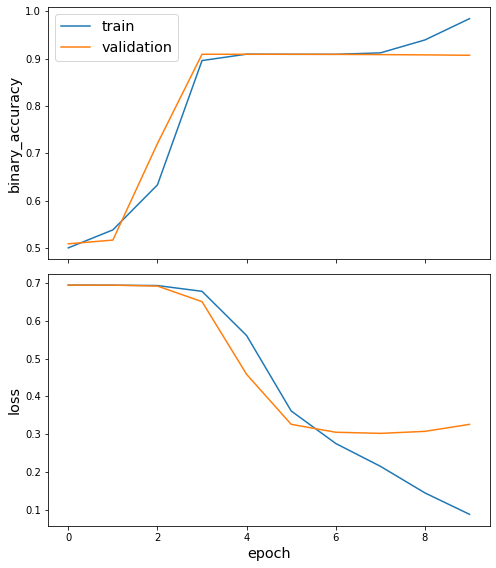

In [408]:
utils.plot_history(history)

## Parameters for ComplEx

In [453]:
epochs = 20
embedding_dimension = 200
negative_samples = 10
learning_rate = 1e-3

## Applying ComplEx on Hetionet (homogeneous)

### Edges

In [410]:
def get_edges_type_list(graph):
    # Cypher for matching all the types of edges 
    query_findAllTypeOfEdges = '''
    match ()-[r]->() return distinct type(r)
    '''
    edges_type_df = match_in_hetio(graph, query_findAllTypeOfEdges)
    edges_type_list = []
    type_num = len(edges_type_df)

    # Add all types in edges_type_list
    for i in range(type_num):
        edges_type_list.append(edges_type_df['type(r)'][i])
    
    return edges_type_list

In [411]:
def map_edge_type(type, edges_type_list):
    edge_tl = [None]
    temp = edges_type_list
    edge_tl = edge_tl + temp
    le = preprocessing.LabelEncoder()
    le.fit(edge_tl)
    t = le.transform([type])
    return t

In [412]:
def get_different_type_edgeDF(graph, edge_type, edges_type_list):
    str1 = '''match (n)-[r:'''
    str2 = edge_type
    str3 = ''']->(m) return 
    n.identifier as source, 
    m.identifier as target, 
    r.unbiased as unbiased
    '''
    query = str1 + str2 + str3
    edge_type_df = match_in_hetio(graph, query)
    temp = map_edge_type(edge_type, edges_type_list)
    # edge_label_list = []
    # for i in range(len(edge_type_df)):
    #     edge_label_list.append(temp[0])
    # edge_type_df["edge_label"] = edge_label_list
    return edge_type_df

In [413]:
def match_all_edges_in_hetio(graph):
    edges_type_list = get_edges_type_list(graph)
    # Get all edges' dataframe and store in edges_df_list
    edges_df_list = []
    for edge_type in edges_type_list:
        edge_type_df = get_different_type_edgeDF(graph, edge_type, edges_type_list)
        edges_df_list.append(edge_type_df)

    return edges_df_list, edges_type_list

In [414]:
# Get a edge dictionary with format:
# {"edge type" : edge's data frame}
def get_edges_dictionary(edges_df_list):
    edges_dictionary = {}

    values = edges_df_list
    for i in range(24):
        if i == 0:
            edges_dictionary["edges"] = values[i]
        else:
            df = edges_dictionary["edges"]
            df = df.append(values[i])
            edges_dictionary["edges"] = df
    return edges_dictionary

In [415]:
def add_index(df_list):
    iter_num = 0
    for i in range(len(df_list)):
        df = df_list[i]
        num = len(df)
        temp = iter_num + num
        index_list = range(iter_num, temp)
        df['index'] = index_list
        iter_num = temp
        df_list[i] = df.set_index('index')
    return df_list

In [416]:
edges_df_list, edges_type_list = match_all_edges_in_hetio(Hetio_graph)
edges_df_list = add_index(edges_df_list)

In [417]:
edges_dic = get_edges_dictionary(edges_df_list)

### Nodes

In [418]:
def get_nodes_labels_list(graph):
    query_findAllLabelsofNodes = '''
    match (n) return distinct labels(n)
    '''
    nodes_labels_df = match_in_hetio(graph, query_findAllLabelsofNodes)
    nodes_labels_list = []
    labels_num = len(nodes_labels_df)

    # Add all labels in nodes_labels_list
    for i in range(labels_num):
        nodes_labels_list.append(nodes_labels_df['labels(n)'][i])
    return nodes_labels_list

In [419]:
def map_nodes_labels(type, nodes_labels_list):
    node_tl = [None]
    list = []
    for i in nodes_labels_list:
        list.append(i[0])
    node_tl = node_tl + list
    le = preprocessing.LabelEncoder()
    le.fit(node_tl)
    t = le.transform([type])
    return t

In [420]:
# Return a single labels' node data frame
def get_different_labels_nodeDF(graph, node_label, nodes_labels_list):
    str1 = '''match (n:'''
    str2 = node_label
    str3 = ''') return n.identifier as index'''
    query = str1 + str2 + str3
    # match the node
    node_type_df = match_in_hetio(graph, query)

    temp = map_nodes_labels(node_label, nodes_labels_list)
    node_label_list = []
    for i in range(len(node_type_df)):
        node_label_list.append(temp[0])
    node_type_df["node_label"] = node_label_list

    node_type_df = node_type_df.set_index("index")
    return node_type_df

In [421]:
# Return a list which contains different labels of nodes' data frame
# And a list which includes all labels of nodes

def match_all_nodes_in_hetio(graph):
    nodes_labels_list = get_nodes_labels_list(graph)
    
    # Get all nodes' dataframe and store in nodes_df_list
    nodes_df_list = []
    for node_label in nodes_labels_list:
        nodes_labels_df = get_different_labels_nodeDF(graph, node_label[0], nodes_labels_list)
        nodes_df_list.append(nodes_labels_df)

    return nodes_df_list, nodes_labels_list

In [422]:
# Get a node dictionary with format:
# {"node label" : node's data frame}
def get_nodes_dictionary(nodes_df_list):
    nodes_dictionary = {}
    values = nodes_df_list
    for i in range(len(nodes_df_list)):
        if i == 0:
            nodes_dictionary["nodes"] = values[i]
        else:
            df = nodes_dictionary["nodes"]
            df = df.append(values[i])
            nodes_dictionary["nodes"] = df
    return nodes_dictionary

In [423]:
nodes_df_list, nodes_labels_list= match_all_nodes_in_hetio(Hetio_graph)

In [424]:
nodes_dic = get_nodes_dictionary(nodes_df_list)

### Import Hetionet into stellargraph

In [425]:
G  = StellarGraph(nodes = nodes_dic, edges=edges_dic)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 47031, Edges: 2250197

 Node types:
  nodes: [47031]
    Features: float32 vector, length 1
    Edge types: nodes-edges->nodes

 Edge types:
    nodes-edges->nodes: [2250197]
        Weights: all 1 (default)
        Features: float32 vector, length 1


### Data Splitting

In [454]:
edges = G.edges(include_edge_type = True)

In [455]:
complex_edge_df = get_complex_edge_df(edges)

In [456]:
train, validation, test = np.split(complex_edge_df.sample(frac = 1, random_state = 42),
                                    [int(.7*len(complex_edge_df)), int(.9*len(complex_edge_df))])

### Generator

In [470]:
generator = KGTripleGenerator(
    G, batch_size = len(train) // 100
)

In [471]:
train_gen = generator.flow(
    train, negative_samples = negative_samples, shuffle = True
)

test_gen = generator.flow(
    test, negative_samples = negative_samples, shuffle = True
)

validation_gen = generator.flow(
    validation, negative_samples = negative_samples
)

In [472]:
Complex = ComplEx(
    generator,
    embedding_dimension = embedding_dimension,
    embeddings_regularizer = regularizers.l2(1e-7)
)

### Model

In [473]:
x_inp, x_out = Complex.in_out_tensors()

In [474]:
model = Model(inputs = x_inp, outputs = x_out)

In [475]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = learning_rate),
    loss = losses.BinaryCrossentropy(from_logits = True),
    metrics = [metrics.BinaryAccuracy(threshold = 0.0)],
)

### Evaluate

In [476]:
init_train_metrics = model.evaluate(train_gen)
init_test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

15/15 [==============================] - 0s 14ms/step - loss: 0.6979 - binary_accuracy: 0.4997

Train Set Metrics of the initial (untrained) model:
	loss: 0.6979
	binary_accuracy: 0.4999

Test Set Metrics of the initial (untrained) model:
	loss: 0.6979
	binary_accuracy: 0.4997


### Train

In [477]:
es = callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [478]:
history = model.fit(
    train_gen, validation_data = test_gen, epochs = epochs, callbacks = [es]
    )

Epoch 1/20
101/101 [==============================] - 9s 74ms/step - loss: 0.6977 - binary_accuracy: 0.5002 - val_loss: 0.6975 - val_binary_accuracy: 0.5006
Epoch 2/20
101/101 [==============================] - 8s 75ms/step - loss: 0.6972 - binary_accuracy: 0.5030 - val_loss: 0.6969 - val_binary_accuracy: 0.5071
Epoch 3/20
101/101 [==============================] - 7s 72ms/step - loss: 0.6961 - binary_accuracy: 0.5638 - val_loss: 0.6933 - val_binary_accuracy: 0.7289
Epoch 4/20
101/101 [==============================] - 8s 76ms/step - loss: 0.6566 - binary_accuracy: 0.8774 - val_loss: 0.5726 - val_binary_accuracy: 0.9090
Epoch 5/20
101/101 [==============================] - 8s 76ms/step - loss: 0.4481 - binary_accuracy: 0.9090 - val_loss: 0.3436 - val_binary_accuracy: 0.9090
Epoch 6/20
101/101 [==============================] - 8s 76ms/step - loss: 0.2886 - binary_accuracy: 0.9088 - val_loss: 0.2546 - val_binary_accuracy: 0.9094
Epoch 7/20
101/101 [==============================] - 7s 7

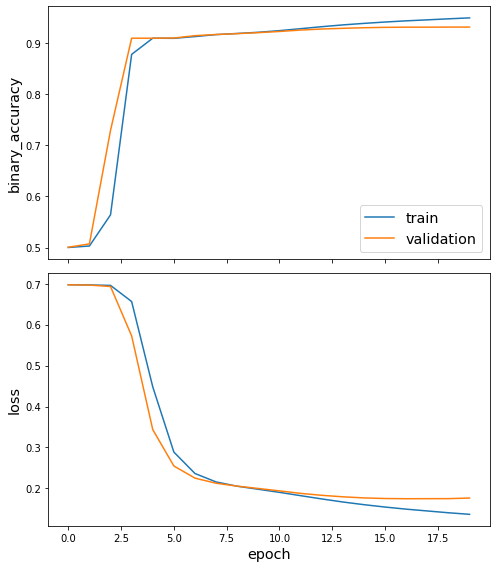

In [479]:
utils.plot_history(history)

In [480]:
init_val_metrics = model.evaluate(validation_gen)

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

29/29 [==============================] - 0s 14ms/step - loss: 0.1760 - binary_accuracy: 0.9307

Validation Set Metrics of the initial (untrained) model:
	loss: 0.1760
	binary_accuracy: 0.9307


## Applying ComplEx on Hetionet (heterogeneous)

### Edges

In [481]:
def get_edges_type_list(graph):
    # Cypher for matching all the types of edges 
    query_findAllTypeOfEdges = '''
    match ()-[r]->() return distinct type(r)
    '''
    edges_type_df = match_in_hetio(graph, query_findAllTypeOfEdges)
    edges_type_list = []
    type_num = len(edges_type_df)

    # Add all types in edges_type_list
    for i in range(type_num):
        edges_type_list.append(edges_type_df['type(r)'][i])
    
    return edges_type_list

In [482]:
# Return a single type's edge data frame
def get_different_type_edgeDF(graph, edge_type, edges_type_list):
    str1 = '''match (n)-[r:'''
    str2 = edge_type
    str3 = ''']->(m) return 
    n.identifier as source, 
    m.identifier as target, 
    r.unbiased as unbiased
    '''
    query = str1 + str2 + str3
    edge_type_df = match_in_hetio(graph, query)
    # temp = map_edge_type(graph, edge_type, edges_type_list)
    # edge_label_list = []
    # for i in range(len(edge_type_df)):
    #     edge_label_list.append(temp[0])
    # edge_type_df["edge_label"] = edge_label_list
    return edge_type_df

In [483]:
# Return a list which contains different types of edges' data frame
# And a list which includes all types of edges

def match_all_edges_in_hetio(graph):
    edges_type_list = get_edges_type_list(graph)
    # Get all edges' dataframe and store in edges_df_list
    edges_df_list = []
    for edge_type in edges_type_list:
        edge_type_df = get_different_type_edgeDF(graph, edge_type, edges_type_list)
        edges_df_list.append(edge_type_df)

    return edges_df_list, edges_type_list

In [484]:
# Get a edge dictionary with format:
# {"edge type" : edge's data frame}
def get_edges_dictionary(edges_df_list, edges_type_list):
    edges_dictionary = {}
    keys = edges_type_list
    values = edges_df_list
    for i in range(len(edges_type_list)):
        edges_dictionary[keys[i]] = values[i]
    return edges_dictionary

In [485]:
def add_index(df_list):
    iter_num = 0
    for i in range(len(df_list)):
        df = df_list[i]
        num = len(df)
        temp = iter_num + num
        index_list = range(iter_num, temp)
        df['index'] = index_list
        iter_num = temp
        df_list[i] = df.set_index('index')
    return df_list

In [486]:
edges_df_list, edges_type_list = match_all_edges_in_hetio(Hetio_graph)
edges_df_list = add_index(edges_df_list)
edges_dictionary = get_edges_dictionary(edges_df_list, edges_type_list)

### Nodes

In [487]:
# map property chromosome into numerical form
def chromosome_into_num(node_type_df):
    c_list = ["0","1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19","20","21","22",
    "X","Y","Un","MT","X|Y"]
    l = node_type_df.chromosome
    list = []
    for i in range(len(l)):
        list.append(l[i])
    le = preprocessing.LabelEncoder()
    le.fit(c_list)
    t_list = le.transform(list)
    node_type_df["chromosome"] = t_list
    return node_type_df

In [488]:
# map property class_type into numerical form
def class_type_into_num(node_type_df):
    c_list = ["Chemical/Ingredient","Physiologic Effect","Mechanism of Action"]
    l = node_type_df.class_type
    list = []
    for i in range(len(l)):
        list.append(l[i])
    le = preprocessing.LabelEncoder()
    le.fit(c_list)
    t_list = le.transform(list)
    node_type_df["class_type"] = t_list
    return node_type_df

In [489]:
# Return a single labels' node data frame
def get_different_labels_nodeDF(graph, node_label):
    str1 = '''match (n:'''
    str2 = node_label
    str3 = ''') return 
    n.identifier as index
    '''
    query = str1 + str2 + str3

    # match the node
    node_type_df = match_in_hetio(graph, query)
    
    node_type_df = node_type_df.set_index("index")
    return node_type_df

In [490]:
def get_nodes_labels_list(graph):
    query_findAllLabelsofNodes = '''
    match (n) return distinct labels(n)
    '''
    nodes_labels_df = match_in_hetio(graph, query_findAllLabelsofNodes)
    nodes_labels_list = []
    labels_num = len(nodes_labels_df)

    # Add all labels in nodes_labels_list
    for i in range(labels_num):
        nodes_labels_list.append(nodes_labels_df['labels(n)'][i])
    return nodes_labels_list

In [491]:
# Return a list which contains different labels of nodes' data frame
# And a list which includes all labels of nodes

def match_all_nodes_in_hetio(graph):
    nodes_labels_list = get_nodes_labels_list(graph)
    
    # Get all nodes' dataframe and store in nodes_df_list
    nodes_df_list = []
    for node_label in nodes_labels_list:
        nodes_labels_df = get_different_labels_nodeDF(graph, node_label[0])
        nodes_df_list.append(nodes_labels_df)

    return nodes_df_list, nodes_labels_list

In [492]:
# Get a node dictionary with format:
# {"node label" : node's data frame}
def get_nodes_dictionary(nodes_df_list, nodes_labels_list):
    nodes_dictionary = {}
    keys = nodes_labels_list
    values = nodes_df_list
    for i in range(len(nodes_labels_list)):
        nodes_dictionary[keys[i][0]] = values[i]
    return nodes_dictionary

In [493]:
nodes_df_list, nodes_labels_list= match_all_nodes_in_hetio(Hetio_graph)

In [494]:
nodes_dictionary = get_nodes_dictionary(nodes_df_list, nodes_labels_list)

### Import into stellargraph

In [495]:
G  = StellarGraph(nodes = nodes_dictionary, edges=edges_dictionary)
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 47031, Edges: 2250197

 Node types:
  Gene: [20945]
    Features: none
    Edge types: Gene-ASSOCIATES_DaG->Disease, Gene-BINDS_CbG->Compound, Gene-COVARIES_GcG->Gene, Gene-DOWNREGULATES_AdG->Anatomy, Gene-DOWNREGULATES_CdG->Compound, ... (11 more)
  BiologicalProcess: [11381]
    Features: none
    Edge types: BiologicalProcess-PARTICIPATES_GpBP->Gene
  SideEffect: [5734]
    Features: none
    Edge types: SideEffect-CAUSES_CcSE->Compound
  MolecularFunction: [2884]
    Features: none
    Edge types: MolecularFunction-PARTICIPATES_GpMF->Gene
  Pathway: [1822]
    Features: none
    Edge types: Pathway-PARTICIPATES_GpPW->Gene
  Compound: [1552]
    Features: none
    Edge types: Compound-BINDS_CbG->Gene, Compound-CAUSES_CcSE->SideEffect, Compound-DOWNREGULATES_CdG->Gene, Compound-INCLUDES_PCiC->PharmacologicClass, Compound-PALLIATES_CpD->Disease, ... (3 more)
  CellularComponent: [1391]
    Features: none
    Edge types: CellularComponent-PAR

### Data Splitting

In [496]:
edges = G.edges(include_edge_type = True)

In [497]:
complex_edge_df = get_complex_edge_df(edges)

In [498]:
train, validation, test = np.split(complex_edge_df.sample(frac = 1, random_state = 42),
                                    [int(.7*len(complex_edge_df)), int(.9*len(complex_edge_df))])

### Generator

In [499]:
generator = KGTripleGenerator(
    G, batch_size = len(train) // 100
)

In [500]:
train_gen = generator.flow(
    train, negative_samples = negative_samples, shuffle = True
)

test_gen = generator.flow(
    test, negative_samples = negative_samples, shuffle = True
)

validation_gen = generator.flow(
    validation, negative_samples = negative_samples
)

In [501]:
Complex = ComplEx(
    generator,
    embedding_dimension = embedding_dimension,
    embeddings_regularizer = regularizers.l2(1e-7)
)

### Model

In [502]:
x_inp, x_out = Complex.in_out_tensors()

In [503]:
model = Model(inputs = x_inp, outputs = x_out)

In [504]:
model.compile(
    optimizer = optimizers.Adam(learning_rate = learning_rate),
    loss = losses.BinaryCrossentropy(from_logits = True),
    metrics = [metrics.BinaryAccuracy(threshold = 0.0)],
)

### Evaluate

In [505]:
init_train_metrics = model.evaluate(train_gen)
init_test_metrics = model.evaluate(test_gen)

print("\nTrain Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_train_metrics):
    print("\t{}: {:0.4f}".format(name, val))

print("\nTest Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

15/15 [==============================] - 0s 13ms/step - loss: 0.6979 - binary_accuracy: 0.5008

Train Set Metrics of the initial (untrained) model:
	loss: 0.6979
	binary_accuracy: 0.5000

Test Set Metrics of the initial (untrained) model:
	loss: 0.6979
	binary_accuracy: 0.5008


### Train

In [506]:
es = callbacks.EarlyStopping(monitor = "val_loss", patience = 10)

In [507]:
history = model.fit(
    train_gen, validation_data = validation_gen, epochs = epochs, callbacks = [es]
    )

Epoch 1/20
101/101 [==============================] - 7s 55ms/step - loss: 0.6977 - binary_accuracy: 0.5001 - val_loss: 0.6975 - val_binary_accuracy: 0.5001
Epoch 2/20
101/101 [==============================] - 5s 53ms/step - loss: 0.6972 - binary_accuracy: 0.5014 - val_loss: 0.6969 - val_binary_accuracy: 0.5016
Epoch 3/20
101/101 [==============================] - 5s 52ms/step - loss: 0.6966 - binary_accuracy: 0.5068 - val_loss: 0.6963 - val_binary_accuracy: 0.5123
Epoch 4/20
101/101 [==============================] - 5s 53ms/step - loss: 0.6948 - binary_accuracy: 0.5775 - val_loss: 0.6897 - val_binary_accuracy: 0.7547
Epoch 5/20
101/101 [==============================] - 5s 53ms/step - loss: 0.6402 - binary_accuracy: 0.8860 - val_loss: 0.5508 - val_binary_accuracy: 0.9090
Epoch 6/20
101/101 [==============================] - 5s 53ms/step - loss: 0.4269 - binary_accuracy: 0.9086 - val_loss: 0.3240 - val_binary_accuracy: 0.9077
Epoch 7/20
101/101 [==============================] - 5s 5

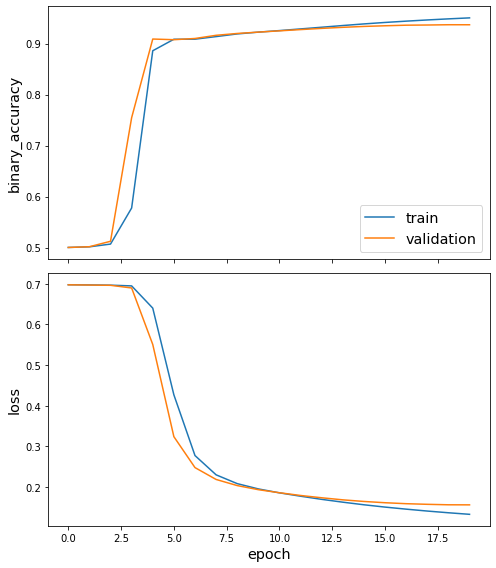

In [508]:
utils.plot_history(history)

In [509]:
init_val_metrics = model.evaluate(validation_gen)

print("\nValidation Set Metrics of the initial (untrained) model:")
for name, val in zip(model.metrics_names, init_val_metrics):
    print("\t{}: {:0.4f}".format(name, val))

29/29 [==============================] - 0s 13ms/step - loss: 0.1560 - binary_accuracy: 0.9372

Validation Set Metrics of the initial (untrained) model:
	loss: 0.1560
	binary_accuracy: 0.9372
